# Advanced Genomic Data Analysis
Welcome to the second Bioinformatics tutorial which will focus on genomic data processing! This session promises to be an exciting dive into understanding some of the fundamental aspects of bioinformatics. Here, we will be dealing with tasks that play pivotal roles in decoding genetic variations and relationships.

# Task 1. DNA Sequences Alignment
This is a foundational technique in bioinformatics. Aligning DNA sequences helps us in identifying regions of similarity that could be a consequence of functional, structural, or evolutionary relationships between the sequences.

There are several tools for performing the alignment, such as:

1. [**BLAST (Basic Local Alignment Search Tool)**](http://www.ncbi.nlm.nih.gov/BLAST/): Developed by the National Center for Biotechnology Information (NCBI), BLAST is among the most widely used tools for comparing an input sequence against a database or another sequence.

2. [**ClustalW & Clustal Omega**](http://www.clustal.org/): Popular tools for multiple sequence alignment.

3. [**MUSCLE (Multiple Sequence Comparison by Log-Expectation)**](http://www.drive5.com/muscle/): Offers multiple sequence alignments with high accuracy.

4. [**MAFFT (Multiple Alignment using Fast Fourier Transform)**](http://mafft.cbrc.jp/alignment/software/): A high-speed multiple sequence alignment program.

5. [**T-Coffee (Tree-based Consistency Objective Function For alignment Evaluation)**](http://tcoffee.crg.cat/): Combines the outputs of several alignment programs.

6. [**Smith-Waterman Algorithm**](https://en.wikipedia.org/wiki/Smith%E2%80%93Waterman_algorithm): Known for accurate local sequence alignment.

7. [**Needleman-Wunsch Algorithm**](https://en.wikipedia.org/wiki/Needleman%E2%80%93Wunsch_algorithm): A global alignment tool suitable for sequences of similar length.

8. [**Bowtie & Bowtie 2**](http://bowtie-bio.sourceforge.net/index.shtml): Ultrafast tools for aligning sequencing reads.

9. [**BWA (Burrows-Wheeler Aligner)**](http://bio-bwa.sourceforge.net/): Useful for mapping sequences against large reference genomes.

10. [**LASTZ**](https://github.com/lastz/lastz): Used for alignments in comparative genomics.

11. [**GATK (Genome Analysis Toolkit)**](https://gatk.broadinstitute.org/hc/en-us): Comprehensive toolkit, including alignment capabilities for next-generation sequencing data.

In this tutorial, we will implement Needleman-Wunsch algorithm. Generally, you can think of it as a string matching problem.

<div style="text-align:center;">
    <img src="https://i.stack.imgur.com/ZyvEM.png" alt="Image Description" width="600">
</div>

An interactive demo for Needleman-Wunsch algorithm: [Here](https://bioboot.github.io/bimm143_W20/class-material/nw/)

In [7]:
def global_alignment(seq1, seq2, match_score=1, mismatch_score=-1, gap_penalty=-2):
    m, n = len(seq1), len(seq2)
    score_matrix = [[0 for _ in range(n+1)] for _ in range(m+1)]

    # Initialization
    for i in range(m+1):
        score_matrix[i][0] = gap_penalty * i
    for j in range(n+1):
        score_matrix[0][j] = gap_penalty * j

    # Fill the score matrix
    for i in range(1, m+1):
        for j in range(1, n+1):
            match = score_matrix[i-1][j-1] + (match_score if seq1[i-1] == seq2[j-1] else mismatch_score)
            delete = score_matrix[i-1][j] + gap_penalty
            insert = score_matrix[i][j-1] + gap_penalty

            score_matrix[i][j] = max(match, delete, insert)

    # Traceback and compute the alignment
    align1, align2 = "", ""
    i, j = m, n
    while i > 0 or j > 0:
        current_score = score_matrix[i][j]
        if i > 0 and score_matrix[i][j] == score_matrix[i-1][j] + gap_penalty:
            align1 += seq1[i-1]
            align2 += "-"
            i -= 1
        elif j > 0 and score_matrix[i][j] == score_matrix[i][j-1] + gap_penalty:
            align1 += "-"
            align2 += seq2[j-1]
            j -= 1
        else:
            align1 += seq1[i-1]
            align2 += seq2[j-1]
            i -= 1
            j -= 1

    return align1[::-1], align2[::-1]

if __name__ == "__main__":
    seq1 = "ATCG"
    seq2 = "TCA"
    alignment = global_alignment(seq1, seq2)
    print("\n".join(alignment))

ATCG
-TCA


# Task 2. Allele Frequency Calculation
Allele frequency refers to how often an allele appears in a population. In the context of a set of aligned sequences (e.g., from a cohort of individuals), you'd count how many times a particular allele appears at a specific position and divide it by the total number of sequences.

In [8]:
def calculate_allele_frequencies(sequences):
    """Calculate allele frequencies at each position for a list of aligned sequences."""
    # Initialize a dictionary for each position
    num_sequences = len(sequences)
    sequence_length = len(sequences[0])
    allele_counts = [{} for _ in range(sequence_length)]

    # Count alleles at each position
    for seq in sequences:
        for i, nucleotide in enumerate(seq):
            if nucleotide in allele_counts[i]:
                allele_counts[i][nucleotide] += 1
            else:
                allele_counts[i][nucleotide] = 1

    # Convert counts to frequencies
    allele_frequencies = []
    for count in allele_counts:
        frequencies = {}
        for allele, allele_count in count.items():
            frequencies[allele] = allele_count / num_sequences
        allele_frequencies.append(frequencies)

    return allele_frequencies

if __name__ == "__main__":
    # Example aligned sequences (all of the same length)
    sequences = [
        "ATCG",
        "ATCG",
        "ATCA",
        "ATGG",
        "CTAG"
    ]
    frequencies = calculate_allele_frequencies(sequences)
    print(frequencies)

[{'A': 0.8, 'C': 0.2}, {'T': 1.0}, {'C': 0.6, 'G': 0.2, 'A': 0.2}, {'G': 0.8, 'A': 0.2}]


# Task 3. Genotype Frequencies Calculation - Hardy-Weinberg Equilibrium

The Hardy-Weinberg principle states that both allele and genotype frequencies in a population will remain constant from generation to generation in the absence of other evolutionary influences.

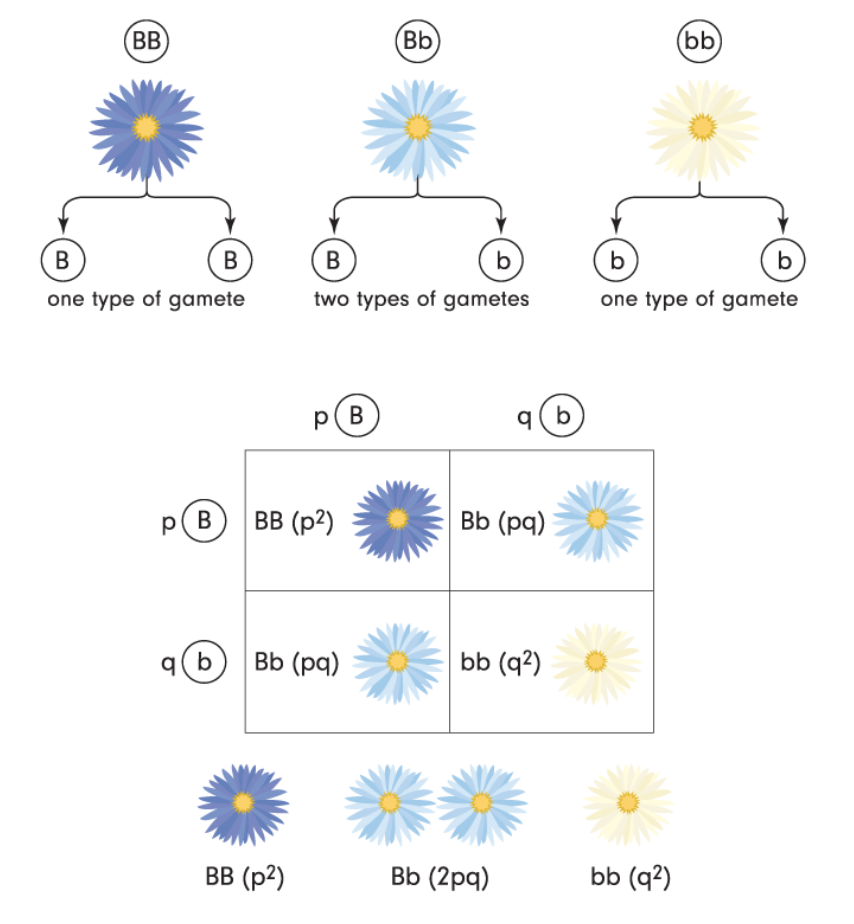

Given a bi-allelic genetic locus with two alleles (A and a), the principle predicts that the proportions of homozygous dominants (AA), heterozygotes (Aa or aA), and homozygous recessives (aa) will be given by the following formulae:

1. \( p^2 \) for AA
2. \( 2pq \) for Aa (or aA)
3. \( q^2 \) for aa

Where:
- \( p \) is the frequency of allele A
- \( q \) is the frequency of allele a
- And \( p + q = 1 \)

In [9]:
def compute_genotype_frequencies(p, q):
    """Compute genotype frequencies using Hardy-Weinberg equilibrium."""
    # Check if p and q sum up to 1
    if not (0 <= p <= 1) or not (0 <= q <= 1) or abs(p + q - 1) > 1e-6:
        print("Allele frequencies (p and q) should sum up to 1.")

    AA = p**2
    Aa = 2 * p * q
    aa = q**2

    return AA, Aa, aa

if __name__ == "__main__":
    # Example allele frequencies
    p = 0.75  # Frequency of allele A
    q = 0.25  # Frequency of allele a

    AA, Aa, aa = compute_genotype_frequencies(p, q)

    print(f"Genotype frequencies based on Hardy-Weinberg equilibrium:")
    print(f"AA (homozygous dominant): {AA:.2f}")
    print(f"Aa (heterozygous): {Aa:.2f}")
    print(f"aa (homozygous recessive): {aa:.2f}")

Genotype frequencies based on Hardy-Weinberg equilibrium:
AA (homozygous dominant): 0.56
Aa (heterozygous): 0.38
aa (homozygous recessive): 0.06


# Task 4. Dot Plot Generation

A dot plot is a simple matrix where the x-axis represents one sequence and the y-axis represents another sequence. When the characters in both sequences match at a given position, a dot is plotted.

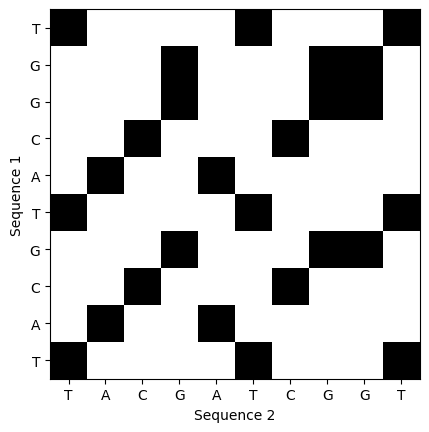

In [10]:
import matplotlib.pyplot as plt

def generate_dotplot(seq1, seq2):
    """Generate a dot plot for two sequences."""
    # Initialize a blank matrix
    matrix = [[0 for _ in range(len(seq2))] for _ in range(len(seq1))]

    # Fill the matrix: 1 indicates a match, 0 indicates no match
    for i in range(len(seq1)):
        for j in range(len(seq2)):
            if seq1[i] == seq2[j]:
                matrix[i][j] = 1

    return matrix

def plot_dotplot(matrix, seq1, seq2):
    """Visualize the dot plot matrix using matplotlib."""
    plt.imshow(matrix, cmap='Greys', origin='lower')
    plt.xlabel("Sequence 2")
    plt.ylabel("Sequence 1")
    plt.xticks(range(len(seq2)), seq2)
    plt.yticks(range(len(seq1)), seq1)
    plt.show()

if __name__ == "__main__":
    seq1 = "TACGTACGGT"
    seq2 = "TACGATCGGT"

    matrix = generate_dotplot(seq1, seq2)
    plot_dotplot(matrix, seq1, seq2)

# Task 5. Whole Genome/Exome Sequencing Variant Calling


<div style="text-align:center;">
    <img src="https://www.melbournebioinformatics.org.au/tutorials/tutorials/longread_sv_calling/media/snv_vs_sv.png" alt="Image Description" width="800">
</div>

Variant calling is the process of identifying variations (typically SNPs and indels) from sequence data. In real-life applications, this would involve working with raw sequencing reads (often in the FASTQ format), mapping these reads to a reference genome (often using tools like BWA or Bowtie), and then calling variants from the aligned reads (using tools like GATK, Samtools, etc.).

In [ ]:
import random

# Simulated reference genome
reference = "AGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCT"

# Simulated sequencing reads from two individuals
individual1 = "AGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCTAGCT"  # Same as reference
individual2 = "AGCTAGCTAGCTAGCTTGCTAGCTAGCTAGCTAGCT"  # One SNP at position 16 (T instead of A)

def call_variants(reference, individual):
    variants = []
    for i in range(len(reference)):
        if reference[i] != individual[i]:
            variants.append((i, reference[i], individual[i]))  # Position, reference nucleotide, individual's nucleotide
    return variants

# Variant calling
variants1 = call_variants(reference, individual1)
variants2 = call_variants(reference, individual2)

print(f"Variants for Individual 1: {variants1}")
print(f"Variants for Individual 2: {variants2}")

# Task 6. Genome-Wide Association Studies (GWAS)

Genome-Wide Association Studies (GWAS) are studies in which many common genetic variants in different individuals are tested to see if any variant is associated with a trait. GWAS are particularly useful for studying complex traits determined by multiple genes.

The core idea behind GWAS is to find statistical associations between genetic markers (usually SNPs, or Single Nucleotide Polymorphisms) and a phenotype or trait. If a particular SNP appears more frequently in people with a disease compared to those without the disease, then that SNP might be related to the disease.

The steps will be as follow:

1. Generate a number of individuals.
2. Each individual will have a set of SNPs.
3. One specific SNP will be associated with the phenotype.
4. Testing for Association: We will perform a statistical test to find out which SNP is most associated with the phenotype.

In [ ]:
import numpy as np
from scipy.stats import chi2_contingency

# Parameters
num_individuals = 1000
num_snps = 100
phenotype_snp_index = 42  # This SNP is associated with the phenotype

# Generate synthetic data
np.random.seed(0)
genotypes = np.random.randint(2, size=(num_individuals, num_snps))  # 0 or 1 for each SNP
phenotypes = np.zeros(num_individuals)

# The individuals with the associated SNP will have a higher chance of showing the phenotype
for i in range(num_individuals):
    if genotypes[i, phenotype_snp_index] == 1:
        phenotypes[i] = np.random.choice([0, 1], p=[0.4, 0.6])  # 60% chance to show phenotype
    else:
        phenotypes[i] = np.random.choice([0, 1], p=[0.7, 0.3])  # 30% chance to show phenotype

# GWAS Testing
p_values = []
for i in range(num_snps):
    table = np.zeros((2, 2))
    for j in range(num_individuals):
        table[genotypes[j, i], int(phenotypes[j])] += 1
    _, p, _, _ = chi2_contingency(table)
    p_values.append(p)

# Find the SNP with the most significant association
min_p_value_index = np.argmin(p_values)
print(f"The SNP most associated with the phenotype is SNP {min_p_value_index} with p-value {p_values[min_p_value_index]}")